# Exercise 4

Work on this before the next lecture on 26 April. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to your GitHub repository for this course before the next lecture starts and post a link to your repository in [this thread](https://github.com/wildtreetech/advanced-computing-2018/issues/8). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

The overall idea of this exercise is to get you using and building convolutional neural networks.

## Question 1

In the last exercise you built a neural network that can classify fashion items using only densely connected layers.

Build on this by using convolutions, pooling, dropout, batch norm, etc in your neural network. Can you outperform your densely connected network?

Start with a small network and a fraction of the data to check if you hooked everything up correctly. Don't go overboard with the size of the network either as even small networks take quite a while to train.

(If you want to experiment with a free GPU checkout https://kaggle.com/kernels .)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import numpy as np

from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Input, Dense
from keras.layers import Activation, Flatten
from keras.layers import MaxPool2D

from keras.datasets import fashion_mnist
from keras import utils


(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# convert our data into a rank 3 tensor
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float64)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype(np.float64)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

num_classes = 10
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

/Users/thead/anaconda/envs/adv-comp-18/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
input_image = Input(shape=(28, 28, 1))

x = Conv2D(32, 5, activation='relu')(input_image)
#x = MaxPool2D(2, strides=2)(x)
x = Conv2D(32, 3, activation='relu')(x)
#x = MaxPool2D(2, strides=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
z = Dense(10, activation='softmax')(x)

convnet = Model(inputs=input_image, outputs=z)

In [4]:
convnet.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [5]:
"""history = convnet.fit(X_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_split=0.2)"""

'history = convnet.fit(X_train, y_train,\n                      batch_size=128,\n                      epochs=10,\n                      verbose=1,\n                      validation_split=0.2)'

In [6]:
import pandas as pd


"""df = pd.DataFrame(history.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
plt.ylabel("loss");"""

'df = pd.DataFrame(history.history)\ndf[[\'acc\', \'val_acc\']].plot()\nplt.ylabel("accuracy")\ndf[[\'loss\', \'val_loss\']].plot(linestyle=\'--\', ax=plt.twinx())\nplt.ylabel("loss");'

## Question 2

For most real world applications we do not have enough labelled images to train a large neural network from scratch. Instead we can use a pre-trained network as a feature transformer and train a smaller model (or even just a logistic regression) on the output of the pre-trained network.

There are several pretrained networks available as part of keras: https://keras.io/applications/. The documentation usually gives some information or links about each network.

The documentation also contains snippets on how to use a pre-trained network as feature transformer ("Extract features with VGG16"). You should be able to generalise from that example using VGG16 to approximately any of the networks available there.

One important thing to not forget is that you need to preprocess your images before feeding them into a pretrained network. Keras provides the functions to do that as well, use them :) You might also need to resize your images first.

The task for this question is to build a classifier that can tell road bikes from mountain bikes. Start with using a pre-trained network as feature transformer and logistic regression as classifier on the output of the pretrained network. Once this works you can experiment with extracting features from earlier layers of the pre-trained network, compare your performance to a small network trained from scratch, try to beat your neural net by extracting features by hand and feeding them to a random forest, increasing your dataset size by [augmenting the data](https://keras.io/preprocessing/image/), etc.

The dataset containing about 100 labelled images for each road and mountain bikes is here: https://github.com/wildtreetech/advanced-computing-2018/blob/master/data/road-and-mountain-bikes.zip

In [17]:
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import numpy as np


# for example load the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')

In [18]:
img_path = '../../data/bikes/mountain_bikes/mountain_bike_0.jpg'
img_path = '../../data/bikes/road_bikes/road_bike_102.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

In [19]:
features.shape

(1, 7, 7, 512)

In [21]:
features.ravel(7*7*512).shape

/Users/thead/anaconda/envs/adv-comp-18/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """Entry point for launching an IPython kernel.


(25088,)

In [27]:
import os

def compute_features(directory):
    features = []
    bike_imgs = os.listdir(directory)
    for bike in bike_imgs:
        img_path = directory + bike
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features_ = model.predict(x)
        features.append(features_.ravel())
        
    return features

road_features = compute_features('../../data/bikes/road_bikes/')
mountain_features = compute_features('../../data/bikes/mountain_bikes/')

In [33]:
X = road_features + mountain_features
X = np.array(X)

In [35]:
y = [0] * len(mountain_features) + [1] * len(road_features)

In [37]:
len(y)

211

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

In [43]:
lr = LogisticRegression()

grid = GridSearchCV(lr, {'C': [0.000001, 0.00001, 0.0001,
                               0.001, 0.01, 0.1, 1.]}, cv=7)
grid.fit(X_train, y_train)

GridSearchCV(cv=7, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [44]:
grid.best_params_

{'C': 0.0001}

In [46]:
grid.score(X_test, y_test)

0.9811320754716981

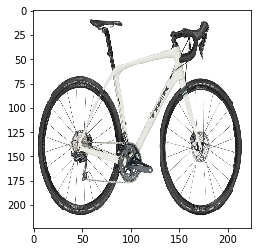

In [47]:
plt.imshow(img)

## Question 3

Think about what project you want to do. What makes a good project? It should use some of what you learnt in this class, there should be labelled data available already, and it should be something you are interested in.

You will have to write a short report on what you did. To write an interesting report you need to tell a story, not just first I did A, then I did B, then I did X and finally D.

It also has to go a bit beyond simply training a classifier or regression model.

An example based on the bike images from the previous question:

A local bike shop wants to keep an eye on sales of bikes on ebay. They specialise in road bikes so they want to be able to filter out all adverts for mountain bikes. They have found that people writing ebay adverts are not very good at correctly labelling their adverts. Can they use machine-learning to help classify adverts?

We investigate labelling adverts based on the image in the advert and study different trade offs in misclassifying bikes. The network was trained on 100 images from a catalog which show bikes on a white background. We compare the performance of the network on the training data and a small set of hand labelled images of bikes in the wild.

In [10]:
!ls ../../data

bikes                       house-train.csv
cal_housing_py3.pkz         melb_data.csv
challenge-test.csv          road-and-mountain-bikes.zip
challenge-train.csv         winequality-red.csv
house-test.csv              winequality-white.csv
